<a href="https://colab.research.google.com/github/tifat58/PET-2020/blob/master/model_inversion_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [116]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Subset, Dataset, DataLoader
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import random
import torchvision.transforms as transforms

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [141]:

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Section: Common Model classes, DataBase classs and functions**

In [202]:

""" LeNet architecture implementation
    This model is used to train mnist and fashion mnist classifier 
"""
from torch import nn, optim
from torch.autograd import Variable
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self,  input_dim=1, output_dim=10):
        super(LeNet, self,).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(self.input_dim, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, self.output_dim)
        
    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [211]:
# LeNet for Cifar10
class LeNet_cifar10(nn.Module):
    def __init__(self,  input_dim=1, output_dim=10):
        super(LeNet_cifar10, self,).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.conv1 = nn.Conv2d(self.input_dim, 6, (5,5), padding=2)
        self.conv2 = nn.Conv2d(6, 16, (5,5))
        self.fc1   = nn.Linear(16*6*6, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, self.output_dim)
        
    def forward(self, x):

        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [118]:
# function to initialize weights with xavier normal distribution
def weight_inits(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_normal_(m.weight)
    
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)

In [213]:
# a = LeNet_cifar10(input_dim=3)
# from torchsummary import summary
# summary(a, (3, 32,32))

In [119]:
# Custom Model dataset class
# input args: name: dataset name {mnist, fashionmnist, cifar10}, root: directory to download data
# returns: train and test loader
from torch.utils.data import Subset
from PIL import Image
from torchvision.datasets import MNIST, CIFAR10, FashionMNIST
import torchvision.transforms as transforms

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class ModelDataset(Dataset):

    def __init__(self, name: str, root='./data'):
        super().__init__()
        self.root = root
        self.name = name

        if name == 'cifar10':

          self.classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
          transform = transforms.Compose([transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
          # target_transform = transforms.Lambda(lambda x: convert_label(x))
          
          self.train_dataset = torchvision.datasets.CIFAR10(root=self.root, train=True, download=True, transform=transform)
          self.train_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=64, shuffle=True, num_workers=2)

          self.test_dataset = torchvision.datasets.CIFAR10(root=self.root, train=False, download=True, transform=transform)
          self.test_loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=64, shuffle=False, num_workers=2)

          self.train_size = (len(self.train_dataset))
          self.test_size = (len(self.test_dataset))


        elif name == 'mnist':
          self.classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
          transform = transforms.Compose([transforms.ToTensor(),
                                        ])
          # target_transform = transforms.Lambda(lambda x: convert_label(x))
          
          self.train_dataset = torchvision.datasets.MNIST(root=self.root, train=True, download=True, transform=transform)
          self.train_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=64, shuffle=True, num_workers=2)

          self.test_dataset = torchvision.datasets.MNIST(root=self.root, train=False, download=True, transform=transform)
          self.test_loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=64, shuffle=False, num_workers=2)

          self.train_size = (len(self.train_dataset))
          self.test_size = (len(self.test_dataset))


        elif name == 'FashionMNIST':
          # self.classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
          self.classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
          transform = transforms.Compose([transforms.ToTensor(),
                                        ])
          # target_transform = transforms.Lambda(lambda x: convert_label(x))
          
          self.train_dataset = torchvision.datasets.FashionMNIST(root=self.root, train=True, download=True, transform=transform)
          self.train_loader = torch.utils.data.DataLoader(self.train_dataset, batch_size=64, shuffle=True, num_workers=2)

          self.test_dataset = torchvision.datasets.FashionMNIST(root=self.root, train=False, download=True, transform=transform)
          self.test_loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=64, shuffle=False, num_workers=2)

          self.train_size = (len(self.train_dataset))
          self.test_size = (len(self.test_dataset))


In [120]:
def train_model(model, criterion, optimizer, data_loader, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train']:
            
            if phase == 'train':
                model.train()  # Set model to training mode
                
                running_loss = 0.0
                running_corrects = 0
                
                for data in data_loader:
                    inputs, labels = data
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    
                    
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(True):
                        outputs = model(inputs)
                        
                        _, preds = torch.max(outputs, 1)
#                         print(preds, labels)
                        loss = criterion(outputs, labels)
                        
                        loss.backward()
                        optimizer.step()
                    
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    
                scheduler.step()
                
                epoch_loss = running_loss / train_size
                epoch_acc = running_corrects.double() / train_size

                print('{} Loss: {:.4f} Acc: {:.4f}'.format('Train', epoch_loss, epoch_acc))
                    
  

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))

    # # load best model weights
    # model.load_state_dict(best_model_wts)
    # return model, best_acc

In [121]:
def test_model(model, criterion, optimizer, data_loader):
    model.eval()   # Set model to evaluate mode
                
    running_loss = 0.0
    running_corrects = 0

    for data in data_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / test_size
    epoch_acc = running_corrects.double() / test_size

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('Val', epoch_loss, epoch_acc))

In [76]:
# process function is kept as identity function
def process(x):
  return x


In [181]:
# sent x with noisy initialization with input shape
# y is the label to predict
# model: trained classifier model
# alpha: total number of iteration/epoch
# beta: early stopping criteria
# gamma: minimum loss value to stop iteration
# lamda: optimizer learning rate

def MI_face(x, y, model, alpha=1500, beta=50, gamma=0.001, lamda=0.001, optim_name='SGD'):
    model.eval()
    if optim_name == 'Adam':
      optimizer = optim.Adam([x], lr=gamma)
      
    else:
      optimizer = optim.SGD([x], lr=gamma, momentum=0.9)

    loss_list = torch.zeros([alpha])
    for i in range(alpha):
        optimizer.zero_grad()
        logits = model(x)
        # x = process(x)

        prob = torch.softmax(logits, -1)
        loss = y * prob.log()
        loss = - loss.sum(-1).mean()
        
        loss.backward()
        optimizer.step()

        loss_list[i] = loss.item()
        # print(loss.item())
        if i > beta:
          marker = True
          for j in range((i - beta), i):
            if loss_list[j] >= loss.item():
              marker = False
              break
          if marker:
            break
        
        if round(loss.item(),4) <= gamma:
          break

        if i % 100 == 0:
            print('loss', loss.item())
            
    print("Image training finished...")
    print("total iteration:", i)
    
    x = torch.tanh(x)
    return x,y

In [157]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def show_image(images):
  pic = images.detach().numpy()
  # print(pic.shape)
  pic_1 = pic[0,0,:,:]
  plt.imshow(pic_1, cmap='Greys', interpolation='nearest')

In [156]:
def save_model(model, model_save_name):
  path = F"/content/gdrive/My Drive/{model_save_name}" 
  torch.save(model.state_dict(), path)
  print("Model Saved...")


**Section: For Fashion MNIST Dataset**

In [122]:
#Training Fashionmnist
fashion_data = ModelDataset(name='FashionMNIST')
print("Dataset: ", fashion_data.name)
train_size = fashion_data.train_size
test_size = fashion_data.test_size

fashion_net = LeNet(input_dim=1)
fashion_net.apply(weight_inits)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(fashion_net.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

Dataset:  FashionMNIST


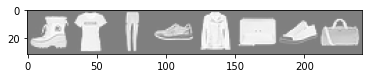

Ankle boot T-shirt/top Trouser Sneaker  Coat   Bag Sneaker   Bag


In [123]:

# get some random training images
dataiter = iter(fashion_data.train_loader)
images, labels = dataiter.next()
# print("Labels: ", labels)

# show images
imshow(torchvision.utils.make_grid(images[0:8]))
print(' '.join('%5s' % fashion_data.classes[labels[j]] for j in range(8)))

In [124]:

train_model(fashion_net, criterion, optimizer_ft, fashion_data.train_loader, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
Train Loss: 2.2907 Acc: 0.0871
Epoch 1/14
----------
Train Loss: 2.2092 Acc: 0.2858
Epoch 2/14
----------
Train Loss: 1.6270 Acc: 0.5496
Epoch 3/14
----------
Train Loss: 0.9063 Acc: 0.6794
Epoch 4/14
----------
Train Loss: 0.7930 Acc: 0.7056
Epoch 5/14
----------
Train Loss: 0.7443 Acc: 0.7255
Epoch 6/14
----------
Train Loss: 0.7105 Acc: 0.7396
Epoch 7/14
----------
Train Loss: 0.6813 Acc: 0.7535
Epoch 8/14
----------
Train Loss: 0.6781 Acc: 0.7557
Epoch 9/14
----------
Train Loss: 0.6752 Acc: 0.7564
Epoch 10/14
----------
Train Loss: 0.6725 Acc: 0.7580
Epoch 11/14
----------
Train Loss: 0.6698 Acc: 0.7592
Epoch 12/14
----------
Train Loss: 0.6671 Acc: 0.7602
Epoch 13/14
----------
Train Loss: 0.6645 Acc: 0.7610
Epoch 14/14
----------
Train Loss: 0.6623 Acc: 0.7625
Training complete in 4m 51s


In [125]:
print("Validation loss and accuracy of Classifier Model in Fashion Mnist Data: ")
test_model(fashion_net, criterion, optimizer_ft, fashion_data.test_loader)

Validation loss and accuracy of Classifier Model in Fashion Mnist Data: 
Val Loss: 0.6828 Acc: 0.7560


In [142]:

# save_model(fashion_net, 'fashion_net.pt')

Model Saved...


In [182]:
y = torch.FloatTensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # change here the class prob
x = torch.randn((1, 1, 28, 28), requires_grad=True)
optimizer = optim.SGD([x], lr=0.001)
images, labels = MI_face(x, y, fashion_net, alpha=3000)

loss 3.380640745162964
loss 1.2136609554290771
loss 0.5900567173957825
loss 0.3937450051307678
loss 0.2928095757961273
loss 0.22746196389198303
loss 0.18509195744991302
loss 0.15628354251384735
loss 0.13519680500030518
loss 0.1185157373547554
loss 0.10358530282974243
loss 0.09224777668714523
loss 0.0830586776137352
loss 0.07539775967597961
loss 0.069245345890522
loss 0.06427235156297684
loss 0.05992158502340317
loss 0.05614003539085388
loss 0.05281130224466324
loss 0.049893639981746674
loss 0.04729137569665909
loss 0.0449463352560997
loss 0.042822446674108505
loss 0.040890131145715714
loss 0.03912528231739998
loss 0.037508774548769
loss 0.036081910133361816
loss 0.03476346656680107
loss 0.03356632962822914
loss 0.032445862889289856
Image training finished...
total iteration: 2999


Trained Image True Label: T-shirt/top (0)
Trained Image Predicted Label: T-shirt/top (0) 
Predicted probability for the class:  0.8084378838539124


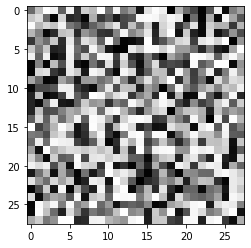

In [189]:

# test_net = LeNet()
# test_net.load_state_dict(torch.load(F"/content/gdrive/My Drive/fashion_net.pt" ))
# test_model(test_net, criterion, optimizer_ft, fashion_data.test_loader)
print("Trained Image True Label: {} ({})".format(fashion_data.classes[torch.argmax(labels).item()], torch.argmax(labels).item()))
y_pred = fashion_net(images)
prob = torch.softmax(y_pred, -1)
print("Trained Image Predicted Label: {} ({}) ".format(fashion_data.classes[prob.argmax().item()], prob.argmax().item()))
print("Predicted probability for the class: ", prob.max().item())
pic = images.detach().numpy()
pic_1 = pic[0,0,:,:]
plt.imshow(pic_1, cmap='Greys', interpolation='nearest')

**Section: For MNIST Dataset**

In [194]:
#Training mnist

mnist_data = ModelDataset(name='mnist')
print("Dataset: ", mnist_data.name)
train_size = mnist_data.train_size
test_size = mnist_data.test_size

mnist_net = LeNet(input_dim=1)
mnist_net.apply(weight_inits)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_mnist = optim.SGD(mnist_net.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_mnist, step_size=15, gamma=0.1)

Dataset:  mnist


In [195]:
train_model(mnist_net, criterion, optimizer_mnist, mnist_data.train_loader, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
Train Loss: 2.2897 Acc: 0.1611
Epoch 1/19
----------
Train Loss: 2.2232 Acc: 0.3158
Epoch 2/19
----------
Train Loss: 1.7837 Acc: 0.5710
Epoch 3/19
----------
Train Loss: 0.7860 Acc: 0.7885
Epoch 4/19
----------
Train Loss: 0.4812 Acc: 0.8600
Epoch 5/19
----------
Train Loss: 0.3887 Acc: 0.8863
Epoch 6/19
----------
Train Loss: 0.3381 Acc: 0.9001
Epoch 7/19
----------
Train Loss: 0.3052 Acc: 0.9101
Epoch 8/19
----------
Train Loss: 0.2809 Acc: 0.9167
Epoch 9/19
----------
Train Loss: 0.2613 Acc: 0.9218
Epoch 10/19
----------
Train Loss: 0.2456 Acc: 0.9272
Epoch 11/19
----------
Train Loss: 0.2312 Acc: 0.9314
Epoch 12/19
----------
Train Loss: 0.2195 Acc: 0.9349
Epoch 13/19
----------
Train Loss: 0.2086 Acc: 0.9384
Epoch 14/19
----------
Train Loss: 0.1988 Acc: 0.9407
Epoch 15/19
----------
Train Loss: 0.1889 Acc: 0.9442
Epoch 16/19
----------
Train Loss: 0.1878 Acc: 0.9446
Epoch 17/19
----------
Train Loss: 0.1868 Acc: 0.9449
Epoch 18/19
----------
Train Loss: 0.1

In [196]:
print("Validation loss and accuracy of Classifier Model in Mnist Data: ")
test_model(mnist_net, criterion, optimizer_mnist, mnist_data.test_loader)

Validation loss and accuracy of Classifier Model in Mnist Data: 
Val Loss: 0.1735 Acc: 0.9492


In [197]:
# save_model(mnist_net, 'mnist_net.pt')

Model Saved...


In [198]:
y = torch.FloatTensor([0.0, 1, 0, 0, 0, 0, 0, 0, 0, 0])
x = torch.randn((1, 1, 28, 28), requires_grad=True)
images, labels = MI_face(x, y, mnist_net, alpha=3000)

loss 8.67250919342041
loss 4.471280097961426
loss 1.1688482761383057
loss 0.3108687996864319
loss 0.16700004041194916
loss 0.11527107656002045
loss 0.08774729818105698
loss 0.06830734759569168
loss 0.05595236271619797
loss 0.04742142930626869
loss 0.041084807366132736
loss 0.03593367710709572
loss 0.031763218343257904
loss 0.028478028252720833
loss 0.02593529410660267
loss 0.023842206224799156
loss 0.022083705291152
loss 0.020592808723449707
loss 0.019295040518045425
loss 0.018181337043642998
loss 0.017166007310152054
loss 0.016264624893665314
loss 0.015453155152499676
loss 0.014718495309352875
loss 0.014070027507841587
loss 0.013476471416652203
loss 0.012929397635161877
loss 0.012422935105860233
loss 0.011959617026150227
loss 0.011530639603734016
Image training finished...
total iteration: 2999


Trained Image True Label: 1 (1)
Trained Image Predicted Label: 1 (1) 
Predicted probability for the class:  0.8938592672348022


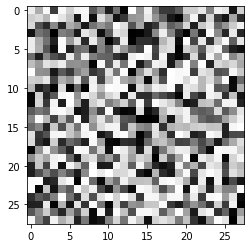

In [199]:

# test_net = LeNet()
# test_net.load_state_dict(torch.load(F"/content/gdrive/My Drive/mnist_net.pt" ))
# test_model(test_net, criterion, optimizer_ft, fashion_data.test_loader)
print("Trained Image True Label: {} ({})".format(mnist_data.classes[torch.argmax(labels).item()], torch.argmax(labels).item()))
y_pred = mnist_net(images)
prob = torch.softmax(y_pred, -1)
print("Trained Image Predicted Label: {} ({}) ".format(mnist_data.classes[prob.argmax().item()], prob.argmax().item()))
print("Predicted probability for the class: ", prob.max().item())
pic = images.detach().numpy()
pic_1 = pic[0,0,:,:]
plt.imshow(pic_1, cmap='Greys', interpolation='nearest')

**Section: For Cifar10 Dataset**

In [215]:
#Training mnist

cifar10_data = ModelDataset(name='cifar10')
print("Dataset: ", cifar10_data.name)
train_size = cifar10_data.train_size
test_size = cifar10_data.test_size

cifar_net = LeNet_cifar10(input_dim=3)
cifar_net.apply(weight_inits)
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_cifar = optim.SGD(cifar_net.parameters(), lr=0.001)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_cifar, step_size=35, gamma=0.1)

Files already downloaded and verified
Files already downloaded and verified
Dataset:  cifar10


In [216]:
train_model(cifar_net, criterion, optimizer_cifar, cifar10_data.train_loader, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
Train Loss: 2.3032 Acc: 0.1047
Epoch 1/19
----------
Train Loss: 2.2499 Acc: 0.1713
Epoch 2/19
----------
Train Loss: 2.1716 Acc: 0.2215
Epoch 3/19
----------
Train Loss: 2.0533 Acc: 0.2638
Epoch 4/19
----------
Train Loss: 1.9399 Acc: 0.3012
Epoch 5/19
----------
Train Loss: 1.8676 Acc: 0.3291
Epoch 6/19
----------
Train Loss: 1.8139 Acc: 0.3485
Epoch 7/19
----------
Train Loss: 1.7668 Acc: 0.3660
Epoch 8/19
----------
Train Loss: 1.7221 Acc: 0.3832
Epoch 9/19
----------
Train Loss: 1.6810 Acc: 0.3998
Epoch 10/19
----------
Train Loss: 1.6443 Acc: 0.4130
Epoch 11/19
----------
Train Loss: 1.6131 Acc: 0.4245
Epoch 12/19
----------
Train Loss: 1.5871 Acc: 0.4350
Epoch 13/19
----------
Train Loss: 1.5648 Acc: 0.4402
Epoch 14/19
----------
Train Loss: 1.5452 Acc: 0.4477
Epoch 15/19
----------
Train Loss: 1.5293 Acc: 0.4552
Epoch 16/19
----------
Train Loss: 1.5270 Acc: 0.4569
Epoch 17/19
----------
Train Loss: 1.5252 Acc: 0.4577
Epoch 18/19
----------
Train Loss: 1.5

In [218]:
print("Validation loss and accuracy of Classifier Model in Mnist Data: ")
test_model(cifar_net, criterion, optimizer_cifar, cifar10_data.test_loader)

Validation loss and accuracy of Classifier Model in Mnist Data: 
Val Loss: 1.5295 Acc: 0.4574


In [219]:
# save_model(cifar_net, 'cifar_net.pt')

Model Saved...


In [220]:
y = torch.FloatTensor([0.0, 0, 1, 0, 0, 0, 0, 0, 0, 0])
x = torch.randn((1, 3, 32, 32), requires_grad=True)
images, labels = MI_face(x, y, cifar_net, alpha=3000)

loss 4.184124946594238
loss 2.906006336212158
loss 1.9802480936050415
loss 1.3816009759902954
loss 0.9820631742477417
loss 0.7331258058547974
loss 0.5716275572776794
loss 0.4621371030807495
loss 0.38599228858947754
loss 0.32995936274528503
loss 0.28739020228385925
loss 0.2539925277233124
loss 0.22687840461730957
loss 0.19931180775165558
loss 0.1773352473974228
loss 0.15956847369670868
loss 0.14495410025119781
loss 0.1330661028623581
loss 0.12300939857959747
loss 0.11436062306165695
loss 0.10688301175832748
loss 0.10034515708684921
loss 0.09455250203609467
loss 0.08941920101642609
loss 0.08482123911380768
loss 0.08072849363088608
loss 0.07701481133699417
loss 0.07362618297338486
loss 0.07052218914031982
loss 0.06766707450151443
Image training finished...
total iteration: 2999


Trained Image True Label: bird (2)
Trained Image Predicted Label: bird (2) 
Predicted probability for the class:  0.6518359184265137


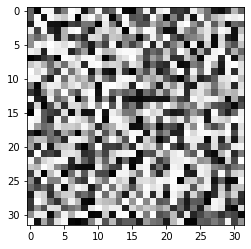

In [222]:
 
# cifar_net = LeNet_cifar10()
# cifar_net.load_state_dict(torch.load(F"/content/gdrive/My Drive/cifar_net.pt" ))
# test_model(cifar_net, criterion, optimizer_ft, cifar10_data.test_loader)
print("Trained Image True Label: {} ({})".format(cifar10_data.classes[torch.argmax(labels).item()], torch.argmax(labels).item()))
y_pred = cifar_net(images)
prob = torch.softmax(y_pred, -1)
print("Trained Image Predicted Label: {} ({}) ".format(cifar10_data.classes[prob.argmax().item()], prob.argmax().item()))
print("Predicted probability for the class: ", prob.max().item())
pic = images.detach().numpy()
pic_1 = pic[0,0,:,:]
plt.imshow(pic_1, cmap='Greys', interpolation='nearest')